<hr style="color:blue">

# <span style="color:cyan"><center> Series de Tiempo con Redes Neuronales
 En este script vamos a ver como resolvemos dos problemas:
  - 1.- Estandarización de los datos: Es útil transformar los datos a una escala de (0,1) o bien a (-1,1).
  
  - 2.- Estacionariedad de los datos: Al menos débilmente estacionaria. Esto es, que tenga media y varianza constantes, es decir, que no cambie en el tiempo.

Comenzaremos pro resolver el problema 2 y así será más fácil resolver 1. 

<hr style="color:blue">

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data=pd.read_csv("PG.csv")
data.head()

,Date,Close
0,01/02/2019,98.550003
1,01/03/2019,104.050003
2,01/04/2019,106.480003
3,01/05/2019,102.910004
4,01/06/2019,109.650002


### <span style="color:cyan"> Tranformaremos la serie para que sea debilmente estacionaria.

Una transforación útil es: Aplicar logaritmos a la serie y despues calcular la primera diferencia.

Digamos que el valor de la serie en el tiempo t es: y(t)
 - Ln_Y = ln(y(t))

 - D(t) = Ln_Y(t) - Ln_Y(t-1) = aprox. igual a [ [ y(t) - y(t-1) ] / y(t-1) ] *100 = Variación porcentual 

In [3]:
data_diff=np.log(data.Close) - np.log(data.Close.shift(periods=1))
data_diff

0          NaN
1     0.054308
2     0.023086
3    -0.034102
4     0.063439
5     0.073730
6     0.018383
7     0.033935
8     0.001045
9    -0.019873
10    0.023001
11   -0.002244
12   -0.095848
13   -0.028941
14    0.069102
15   -0.016682
16    0.031002
17    0.092211
18    0.053529
19    0.004760
20   -0.013691
21    0.012828
22    0.001942
23   -0.081811
24   -0.037186
25    0.091971
26   -0.014953
27    0.010661
28    0.000593
29    0.052689
30    0.001124
31   -0.018357
32    0.022562
33    0.011058
34    0.123469
35   -0.019320
36   -0.028832
37   -0.020021
38    0.049476
39   -0.082204
40   -0.028047
41   -0.034528
42   -0.007007
43   -0.088555
44    0.064563
45    0.102192
46    0.015962
47   -0.062482
48   -0.034439
49    0.077803
50    0.023463
Name: Close, dtype: float64

In [4]:
data["Var"]=data_diff   # Creamos una columna para la variacion conceptual
data.head(10)

,Date,Close,Var
0,01/02/2019,98.550003,NaN
1,01/03/2019,104.050003,0.054308
2,01/04/2019,106.480003,0.023086
3,01/05/2019,102.910004,-0.034102
4,01/06/2019,109.650002,0.063439
5,01/07/2019,118.040001,0.073730
6,01/08/2019,120.230003,0.018383
7,01/09/2019,124.379997,0.033935
8,01/10/2019,124.510002,0.001045
9,01/11/2019,122.059998,-0.019873


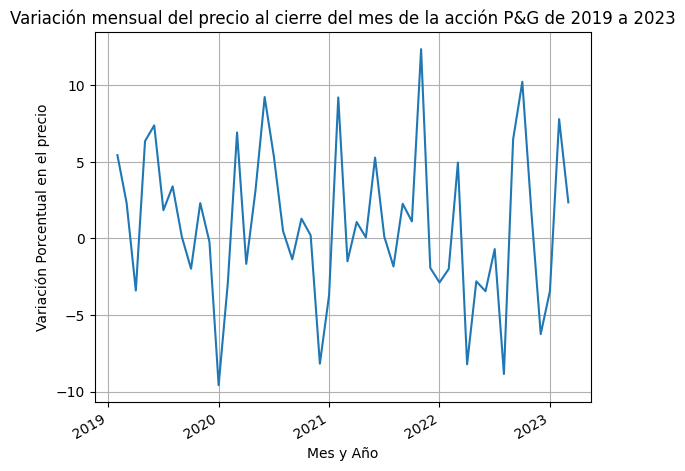

In [5]:
plt.plot(data["Date"],data["Var"]*100)
plt.title("Variación mensual del precio al cierre del mes de la acción P&G de 2019 a 2023")
plt.xticks(np.arange(0,52,12),["2019","2020","2021","2022","2023"], rotation=30,ha="right")
plt.xlabel("Mes y Año")
plt.ylabel("Variación Porcentual en el precio")
plt.grid()

In [6]:
# Vmaos a darle formato a la serie de tiempo:

# Cuántas observaciones tenemos?
n_obs = len(data) - 1   # El menos uno es debido a que perdimos una observacion al aplicar una diferencia.
n_obs

50

In [7]:
# Dividimos el conjunto de datos en entrenamiento y prueba:
n_train = int(n_obs*0.8)    # Tomamos el 80% de los datos para entrenar
train = np.array(data.Var[1:n_train+1]).reshape(-1,1)
test = np.array(data.Var[n_train+1:]).reshape(-1,1)
test

array([[-0.03452758],
       [-0.00700745],
       [-0.08855475],
       [ 0.06456326],
       [ 0.10219226],
       [ 0.01596199],
       [-0.062482  ],
       [-0.0344394 ],
       [ 0.07780344],
       [ 0.02346323]])

In [8]:
# Preprocesamiento de los datos

# Reescalamos los datos al intervalo (0,1):
from sklearn.preprocessing import MinMaxScaler

escala = MinMaxScaler()
train = escala.fit_transform(train)
test = escala.transform(test)

In [9]:
# Construimos los atributos (features) y el target:

# Rezago: Es el número de obsevaciones anteriores que vamos a emplear para la predicción dle siguiente.
def crear_dataset(data,rezago):
    X,Y=[],[]
    for i in range(len(data)-rezago):
        a=data[i:(i+rezago)]
        X.append(a)
        Y.append(data[i+rezago])
    return(np.array(X), np.array(Y))

In [10]:
# Vamos a crear el X_train,X_test,Y_train,Y_test
rezago=1
X_train,Y_train = crear_dataset(train,rezago)
X_test,Y_test = crear_dataset(test,rezago)

In [11]:
Y_test

array([[0.40507783],
       [0.03325414],
       [0.73141214],
       [0.90298559],
       [0.50980945],
       [0.15213567],
       [0.27999888],
       [0.79178219],
       [0.54401217]])

In [12]:
# Arquitectura de la red neuronal
modelo=Sequential()
modelo.add(Dense(units=50,input_dim=rezago,activation="relu"))
modelo.add(Dense(units=32,activation="relu"))
modelo.add(Dropout(0.3))
modelo.add(Dense(units=1))
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                100       
                                                                 
 dense_1 (Dense)             (None, 32)                1632      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,765
Trainable params: 1,765
Non-trainable params: 0
_________________________________________________________________


In [13]:
# compilar el modelo
modelo.compile(loss="mean_squared_error", optimizer="Adam", metrics="mean_squared_error")

In [14]:
# Entrenamos el modelo
historial=modelo.fit(X_train,Y_train, epochs=70,batch_size=64,validation_data=(X_test,Y_test))


Epoch 1/70
1/1 [==============================] - 1s 806ms/step - loss: 0.2590 - mean_squared_error: 0.2590 - val_loss: 0.2859 - val_mean_squared_error: 0.2859
Epoch 2/70
1/1 [==============================] - 0s 29ms/step - loss: 0.2449 - mean_squared_error: 0.2449 - val_loss: 0.2775 - val_mean_squared_error: 0.2775
Epoch 3/70
1/1 [==============================] - 0s 29ms/step - loss: 0.2416 - mean_squared_error: 0.2416 - val_loss: 0.2693 - val_mean_squared_error: 0.2693
Epoch 4/70
1/1 [==============================] - 0s 31ms/step - loss: 0.2279 - mean_squared_error: 0.2279 - val_loss: 0.2613 - val_mean_squared_error: 0.2613
Epoch 5/70
1/1 [==============================] - 0s 30ms/step - loss: 0.2278 - mean_squared_error: 0.2278 - val_loss: 0.2536 - val_mean_squared_error: 0.2536
Epoch 6/70
1/1 [==============================] - 0s 29ms/step - loss: 0.2129 - mean_squared_error: 0.2129 - val_loss: 0.2463 - val_mean_squared_error: 0.2463
Epoch 7/70
1/1 [=============================

In [15]:
# Evaluamos el desempeño predictivo del modelo, evaluando el modelo en el conjunto de prueba.
loss_test , mse_test = modelo.evaluate(X_test,Y_test)
print(f"El error cuadratico medio en el conjunto de prueba es: {mse_test:.4}")


1/1 [==============================] - 0s 22ms/step - loss: 0.0887 - mean_squared_error: 0.0887
El error cuadratico medio en el conjunto de prueba es: 0.08867


<Figure size 640x480 with 0 Axes>

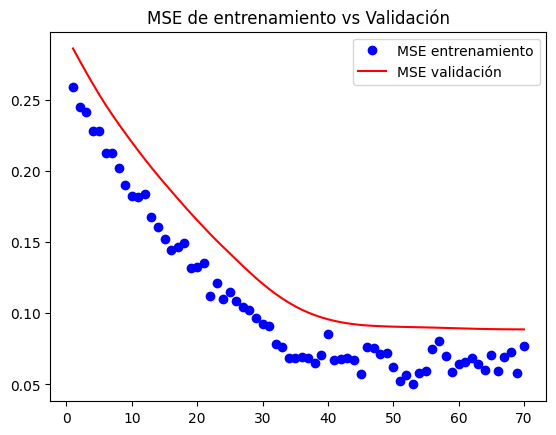

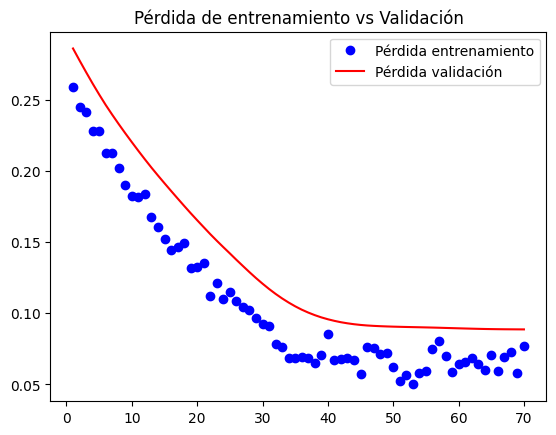

<Figure size 640x480 with 0 Axes>

In [16]:
# Análisis del modelo

# Desempeño de la métrica y de la función de pérdida

mse=historial.history["mean_squared_error"]
val_mse=historial.history["val_mean_squared_error"]
loss=historial.history["loss"]
val_loss=historial.history["val_loss"]
epocas=range(1,len(mse)+1)

plt.plot(epocas, mse, "ob", label="MSE entrenamiento")
plt.plot(epocas, val_mse, "r", label="MSE validación")
plt.title("MSE de entrenamiento vs Validación")
plt.legend()
plt.figure()

plt.plot(epocas, loss, "ob", label="Pérdida entrenamiento")
plt.plot(epocas, val_loss, "r", label="Pérdida validación")
plt.title("Pérdida de entrenamiento vs Validación")
plt.legend()
plt.figure()

1Observamos que la red no está sobreentrenada o subentrenada.

In [17]:
# Hacemos las predicciones:
Y_pred = modelo.predict(X_test)
Y_pred  # Estas son las predicciones de los datos reescalados

1/1 [==============================] - 0s 69ms/step


array([[0.3624477 ],
       [0.4158712 ],
       [0.24849738],
       [0.55229044],
       [0.623979  ],
       [0.45969817],
       [0.30655566],
       [0.3626189 ],
       [0.5775149 ]], dtype=float32)

In [18]:
# Para hacer las predicciones de la serie en los valores originales, esto es, las predicciones de los variaciones porcentuales. 
# Entonces tenemos que regresar las predicciones a la escala original.

# Por ejemplo, para rescatar los valores originales a partir de los transformados:
Y_test = escala.inverse_transform(Y_test)
Y_test

array([[-0.00700745],
       [-0.08855475],
       [ 0.06456326],
       [ 0.10219226],
       [ 0.01596199],
       [-0.062482  ],
       [-0.0344394 ],
       [ 0.07780344],
       [ 0.02346323]])

In [19]:
# Enronces, las predicciones de las variaciones porcentuales son:
Y_pred = escala.inverse_transform(modelo.predict(X_test))
Y_pred

1/1 [==============================] - 0s 18ms/step


array([[-0.01635696],
       [-0.00464028],
       [-0.04134822],
       [ 0.0252788 ],
       [ 0.04100132],
       [ 0.00497173],
       [-0.02861505],
       [-0.01631942],
       [ 0.03081095]], dtype=float32)

In [20]:
# La raiz cuadrada del error cuadrático medio es:
np.sqrt(np.mean(Y_pred-Y_test)**2)

# Tenemos un error estandar del 2.5%

0.010746411287050488

In [21]:
# Vamos a agregar ahora las predicciones de las variaciones en el conjunto de entrenamiento y prueba al DataFrame, así como los precios al cierre predichos:
data["Var_train"] = np.nan
data.loc[rezago+1:len(X_train)+rezago,"Var_train"] = escala.inverse_transform(modelo.predict(X_train))
data.loc[len(X_train)+2*rezago+1:,"Var_test"] = escala.inverse_transform(modelo.predict(X_test))
data

1/1 [==============================] - 0s 19ms/step


,Date,Close,Var,Var_train,Var_test
0,01/02/2019,98.550003,NaN,NaN,NaN
1,01/03/2019,104.050003,0.054308,NaN,NaN
2,01/04/2019,106.480003,0.023086,0.020994,NaN
3,01/05/2019,102.910004,-0.034102,0.007948,NaN
4,01/06/2019,109.650002,0.063439,-0.016176,NaN
5,01/07/2019,118.040001,0.073730,0.024809,NaN
6,01/08/2019,120.230003,0.018383,0.029109,NaN
7,01/09/2019,124.379997,0.033935,0.005983,NaN
8,01/10/2019,124.510002,0.001045,0.012481,NaN
9,01/11/2019,122.059998,-0.019873,-0.001261,NaN


In [22]:
102.91*(1+0.002448)

103.16192368

In [23]:
# Vamos a agregar ahora las predicciones de los precios al cierre:
data["Close_train"] = np.nan
for i in range(1,len(data)):
    data.loc[i,"Close_train"] = (1+data.loc[i,"Var_train"])*data.loc[i-1,"Close"]

data["Close_test"] = np.nan
for i in range(1,len(data)):
    data.loc[i,"Close_test"] = (1+data.loc[i,"Var_test"])*data.loc[i-1,"Close"]
    
data

,Date,Close,Var,Var_train,Var_test,Close_train,Close_test
0,01/02/2019,98.550003,NaN,NaN,NaN,NaN,NaN
1,01/03/2019,104.050003,0.054308,NaN,NaN,NaN,NaN
2,01/04/2019,106.480003,0.023086,0.020994,NaN,106.234391,NaN
3,01/05/2019,102.910004,-0.034102,0.007948,NaN,107.326326,NaN
4,01/06/2019,109.650002,0.063439,-0.016176,NaN,101.245341,NaN
5,01/07/2019,118.040001,0.073730,0.024809,NaN,112.370298,NaN
6,01/08/2019,120.230003,0.018383,0.029109,NaN,121.476023,NaN
7,01/09/2019,124.379997,0.033935,0.005983,NaN,120.949378,NaN
8,01/10/2019,124.510002,0.001045,0.012481,NaN,125.932420,NaN
9,01/11/2019,122.059998,-0.019873,-0.001261,NaN,124.352975,NaN


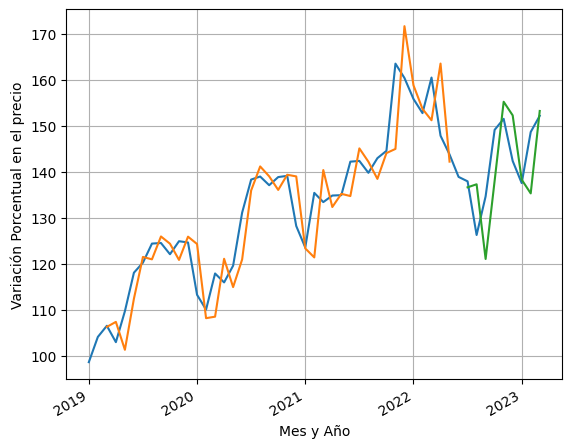

In [24]:
# Gráficas
plt.plot(data.Date,data.Close)
plt.plot(data.Date,data.Close_train)
plt.plot(data.Date,data.Close_test)
plt.xticks(np.arange(0,52,12),["2019","2020","2021","2022","2023"], rotation=30,ha="right")
plt.xlabel("Mes y Año")
plt.ylabel("Variación Porcentual en el precio")
plt.grid()

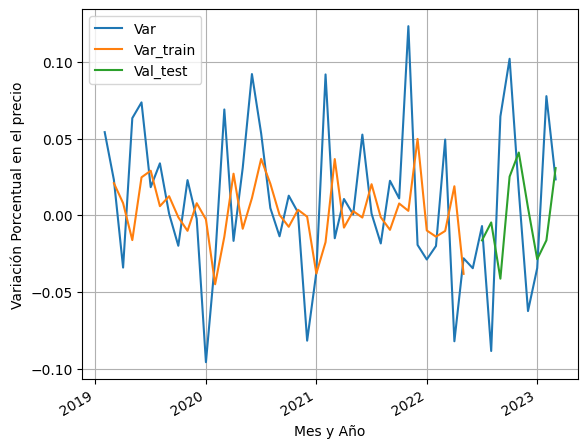

In [25]:
# Gráficas
plt.plot(data.Date,data.Var,label="Var")
plt.plot(data.Date,data.Var_train,label="Var_train")
plt.plot(data.Date,data.Var_test,label="Val_test")
plt.xticks(np.arange(0,52,12),["2019","2020","2021","2022","2023"], rotation=30,ha="right")
plt.xlabel("Mes y Año")
plt.ylabel("Variación Porcentual en el precio")
plt.grid()
plt.legend()

In [26]:
# Como hacemos las predicciones.
# Lo que el modelo predice son las variaciones.
# Como solo tenemos un rezago :

# La última variación observada es:
y = data.Var[n_obs].reshape(-1,1)
y = escala.transform(y)
y_predichos = escala.inverse_transform(modelo.predict(y))
y_predichos     # Variacion porcentual
close_pred = (1+y_predichos)*data.Close[n_obs]
y_predichos, close_pred

1/1 [==============================] - 0s 47ms/step


(array([[0.00810597]], dtype=float32), array([[153.45389]], dtype=float32))